In [76]:
import os, sys
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
SRC = os.path.join(ROOT, 'src')
sys.path.append(SRC)

import matplotlib.pyplot as plt
import IPython.display as ipd
import mirdata
import librosa
import warnings
import numpy as np
from numpy import VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=VisibleDeprecationWarning)
import yaml

from inference.tracker import Audio2Beats
from utils.visualisation import plot_sonify, plot_spec

%matplotlib inline

In [77]:
data_home = '../../../datasets/CMR'

In [78]:
carn = mirdata.initialize('compmusic_carnatic_rhythm', version='full_dataset_1.0', data_home=data_home, )
#carn.download(['index'])
#carn.download() # run once and comment line
#carn.validate()
carn_tracks = carn.load_tracks()
carn_keys = list(carn_tracks.keys())

## Test on the selected Track

For a track in trainfold 1, choose a checkpoint trained on trainfold 2 and vice-versa

In [115]:
#ct = carn.choice_track()
ct = carn_tracks['11040']
trainfold = 1

In [116]:
# use an example audio file provided
audio_path = ct.audio_path

start_time = 30.0  # in seconds
duration = 10.0   # None for entire track. Otherwise in seconds

# load audio file
y, sr = librosa.load(audio_path, sr=None)

# print sampling rate
print('sr: ', sr)

# beats
beats = ct.beats.times.astype(np.float32)
labels = ct.beats.positions.astype(int)

sr:  44100


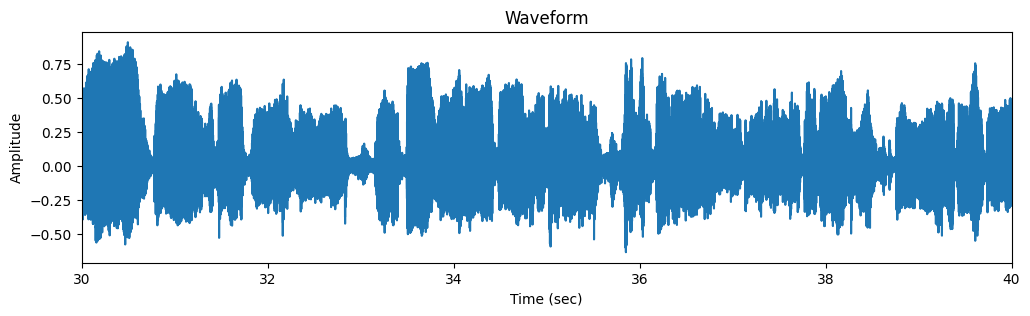

In [117]:
plot_sonify(y=y, sr=sr, start_time=start_time, duration=duration)

## Plot Ground Truth for Example Track

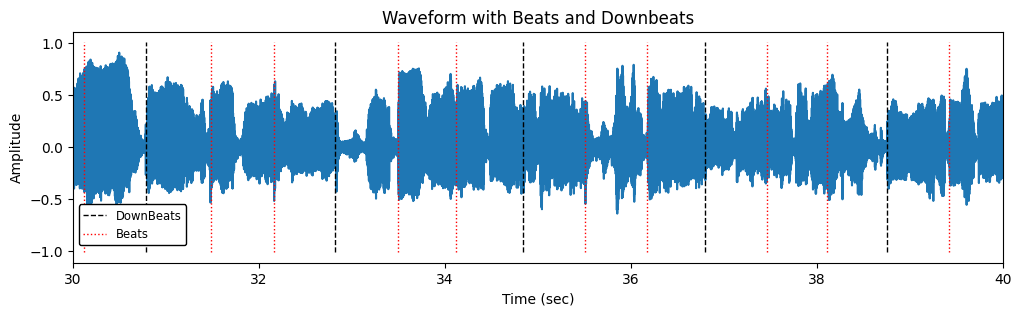

In [118]:
plot_sonify(y=y, sr=sr, start_time=start_time, duration=duration, beats=beats, labels=labels)

## Predict on Example Track

### Load Checkpoint and model config (optional)

For a track in trainfold 1, choose a checkpoint trained on trainfold 2 and vice-versa

In [119]:
testfold = 3-trainfold
ckpt = f'tcn_carnatic_fs-trainfold{testfold}-run3.ckpt'

ckpts_home = '../pretrained/tcn_carnatic_fs/'
ckpt_path = os.path.join(ckpts_home, ckpt)

In [120]:
# if trained on a custom network configuration, import the model configuration and pass it to the Audio2Beats model_params parameter (illustrated below). 
with open('../config/model.yaml', 'r') as f:
    config = yaml.safe_load(f)
    model_params = {
                    "N_FILTERS": config['model']['n_filters'],
                    "KERNEL_SIZE": config['model']['kernel_size'],
                    "DROPOUT": config['model']['dropout'],
                    "N_DILATIONS": config['model']['n_dilations'],
                    }

### Predict

In [121]:
a2b = Audio2Beats(ckpt_path)
pred = a2b.predict(ct.audio_path)

pred_beats = pred[:, 0].astype(np.float32)
pred_labels = pred[:, 1].astype(int)

### Plot

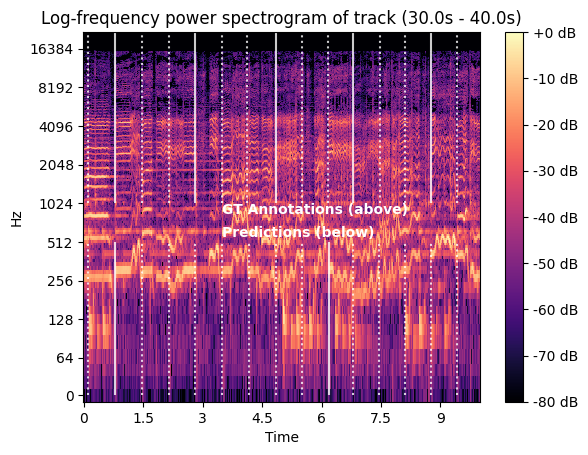

In [122]:
plot_spec(y=y, sr=sr, start_time=start_time, duration=duration, gt_beats=beats, gt_labels=labels, pred_beats=pred_beats, pred_labels=pred_labels)

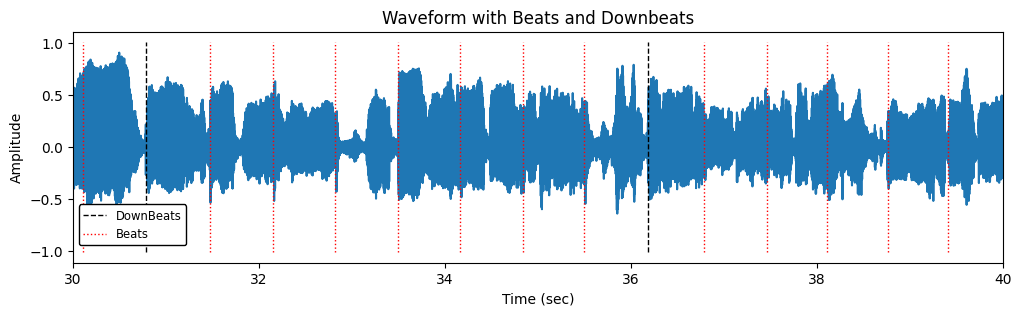

In [123]:
plot_sonify(y=y, sr=sr, start_time=start_time, duration=duration, beats=pred_beats, labels=pred_labels)

### Save as .beats file

In [124]:
# Create exports directory if it doesn't exist
os.makedirs('./exports', exist_ok=True)

# Save predictions as .beats file
export_path = f'./exports/{ct.track_id}.beats'

# Write predictions to file with tab separator
with open(export_path, 'w') as f:
    for beat_time, beat_label in zip(pred_beats, pred_labels):
        f.write(f"{beat_time:.3f}\t{beat_label}\n")

print(f"Predictions saved to: {export_path}")

Predictions saved to: ./exports/11040.beats
